In [1]:
import numpy as np
from space_exploration.beans.dataset_bean import Dataset
from space_exploration.dataset.transforms.AllTransforms import TransformationReferences
dataset_name = "re200-sr1etot"
dataset = Dataset.get_dataset_or_fail(dataset_name)
# ds = dataset.get_training_dataset(64, TransformationReferences.DEFAULT_UNCHANGED.transformation, TransformationReferences.DEFAULT_UNCHANGED.transformation, size=1000)
ds = dataset.get_training_dataset(64, TransformationReferences.COMPONENT_NORMALIZE.transformation, TransformationReferences.Y_ALONG_COMPONENT_NORMALIZE.transformation, size=1000)
xs = np.array([x.numpy() for x, y in ds])
ys = np.array([y.numpy() for x, y in ds])

Loading std & mean of dataset re200-sr1etot
Loading stds & means of dataset re200-sr1etot
⌛ Initializing Dataset...
X...
[########################################] | 100% Completed | 578.98 ms
Y...
[########################################] | 100% Completed | 6.55 ss


In [2]:
from ax.service.managed_loop import optimize
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep

import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter

def get_correlation(blurred_diff, field):
    # blurred diff shape: 64, 1, 64
    # field shape : 64, 64, 64
    blurr_y_first = np.transpose(np.broadcast_to(blurred_diff, field.shape), (1, 0, 2))
    field_y_first = np.transpose(field, (1, 0, 2))
    correlation, _ = pearsonr(blurr_y_first.reshape(64, -1), field_y_first.reshape(64, -1), axis=1)
    return correlation


def dog(layer, s1, s2):
    return gaussian_filter(layer, s1) - gaussian_filter(layer, s2)

def get_avg_corr(images, fields, s1, s2):
     return np.array([get_correlation(dog(image, s1, s2), layer) for image, layer in zip(images, fields)]).mean(axis=0)


def run_exp(evaluation, target_component_in, target_component_out):
    images = xs[:, target_component_in]
    fields = ys[:, target_component_out]
        
    def get_fit_score(s1, s2):
        average_y_correlations = get_avg_corr(images, fields, s1, s2)
        if np.isnan(average_y_correlations).any():
            print("WARNING NAN VALUE")
            return -100000
        return evaluation(average_y_correlations)
        
    from ax import Client, RangeParameterConfig
    
    # 1. Initialize the Client.
    client = Client()
    
    # 2. Configure where Ax will search.
    client.configure_experiment(
        name="dog research",
        parameters=[
            RangeParameterConfig(
                name="s1",
                bounds=(0.0, 64.0),
                parameter_type="float",
            ),
            RangeParameterConfig(
                name="s2",
                bounds=(0.0, 64.0),
                parameter_type="float",
            ),
        ],
        parameter_constraints=[
            "s2 - s1 >= 0.0",  # Enforces s2 ≥ s1
        ],
    )
     
    
    # 3. Configure a metric Ax will target (see other Tutorials for adding constraints,
    # multiple objectives, tracking metrics etc.)
    client.configure_optimization(objective="correlation")
    
    
    
    try:
        for _ in range(30):
            for trial_index, parameters in client.get_next_trials(max_trials=1).items():
                raw_data = {
                        "correlation": get_fit_score(parameters["s1"], parameters["s2"])
                    }
                client.complete_trial(
                    trial_index=trial_index,
                    raw_data=raw_data,
                )
            
                print(f"Completed trial {trial_index} with {raw_data=}")
    except KeyboardInterrupt  as e:
        pass
    # 5. Obtain the best-performing configuration; the true minimum for the booth
    client.get_best_parameterization()

[WARNING 07-14 10:45:39] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.
/tmp/ipykernel_146829/1665638213.py:2: DeprecationWarning: Please import from 'ax.generation_strategy.generation_strategy' instead of 'ax.modelbridge.generation_strategy'. The latter is deprecated and will be removed in a future release.
  from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep


In [3]:
run_exp(lambda corrs: corrs[0:10].mean(), 0, 0)

/tmp/ipykernel_146829/1665638213.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(blurr_y_first.reshape(64, -1), field_y_first.reshape(64, -1), axis=1)


WARNING NAN VALUE
Completed trial 0 with raw_data={'correlation': -100000}
Completed trial 1 with raw_data={'correlation': np.float32(0.0869336)}
Completed trial 2 with raw_data={'correlation': np.float32(0.10203812)}
Completed trial 3 with raw_data={'correlation': np.float32(0.10188581)}
Completed trial 4 with raw_data={'correlation': np.float32(0.096983954)}
Completed trial 5 with raw_data={'correlation': np.float32(0.08851749)}
Completed trial 6 with raw_data={'correlation': np.float32(0.121437885)}
Completed trial 7 with raw_data={'correlation': np.float32(0.09936616)}


/tmp/ipykernel_146829/1665638213.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(blurr_y_first.reshape(64, -1), field_y_first.reshape(64, -1), axis=1)


WARNING NAN VALUE
Completed trial 8 with raw_data={'correlation': -100000}
Completed trial 9 with raw_data={'correlation': np.float32(0.13568404)}
Completed trial 10 with raw_data={'correlation': np.float32(0.09583606)}
Completed trial 11 with raw_data={'correlation': np.float32(0.13595489)}
Completed trial 12 with raw_data={'correlation': np.float32(0.087532535)}
Completed trial 13 with raw_data={'correlation': np.float32(0.13533333)}
Completed trial 14 with raw_data={'correlation': np.float32(0.12423517)}


/tmp/ipykernel_146829/1665638213.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(blurr_y_first.reshape(64, -1), field_y_first.reshape(64, -1), axis=1)


WARNING NAN VALUE
Completed trial 15 with raw_data={'correlation': -100000}
Completed trial 16 with raw_data={'correlation': np.float32(0.11519842)}
Completed trial 17 with raw_data={'correlation': np.float32(0.110179104)}


/tmp/ipykernel_146829/1665638213.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(blurr_y_first.reshape(64, -1), field_y_first.reshape(64, -1), axis=1)


WARNING NAN VALUE
Completed trial 18 with raw_data={'correlation': -100000}
Completed trial 19 with raw_data={'correlation': np.float32(0.08801744)}
Completed trial 20 with raw_data={'correlation': np.float32(0.13178219)}
Completed trial 21 with raw_data={'correlation': np.float32(0.09428569)}
Completed trial 22 with raw_data={'correlation': np.float32(0.0918179)}


/data3/chancrin/code/3D-GAN/.venv/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Completed trial 23 with raw_data={'correlation': np.float32(0.086412236)}
Completed trial 24 with raw_data={'correlation': np.float32(0.11325256)}
Completed trial 25 with raw_data={'correlation': np.float32(0.09185059)}
Completed trial 26 with raw_data={'correlation': np.float32(0.13408092)}
Completed trial 27 with raw_data={'correlation': np.float32(0.12930985)}
Completed trial 28 with raw_data={'correlation': np.float32(0.08891303)}
Completed trial 29 with raw_data={'correlation': np.float32(0.08605282)}


[WARNING 07-14 10:51:16] ax.modelbridge.cross_validation: Metric correlation was unable to be reliably fit.
[WARNING 07-14 10:51:16] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 07-14 10:51:16] ax.service.utils.best_point: Model fit is poor and data on objective metric correlation is noisy; interpret best points results carefully.


In [ ]:
run_exp(lambda corrs: corrs[10:20].mean(), 0, 0)

In [ ]:
run_exp(lambda corrs: corrs[20:30].mean(), 0, 0)

In [ ]:
run_exp(lambda corrs: corrs[30:40].mean(), 0, 0)

In [ ]:
run_exp(lambda corrs: corrs[40:50].mean(), 0, 0)

In [ ]:
run_exp(lambda corrs: corrs[50:60].mean(), 0, 0)

In [ ]:
run_exp(lambda corrs: corrs[60:64].mean(), 0, 0)

In [17]:
full_ds = dataset.get_training_dataset(64, TransformationReferences.COMPONENT_NORMALIZE.transformation, TransformationReferences.Y_ALONG_COMPONENT_NORMALIZE.transformation, size=1000)
full_xs = np.array([x.numpy() for x, y in full_ds])
full_ys = np.array([y.numpy() for x, y in full_ds])


Loading std & mean of dataset re200-sr1etot
Loading stds & means of dataset re200-sr1etot
⌛ Initializing Dataset...
X...
[########################################] | 100% Completed | 559.02 ms
Y...
[########################################] | 100% Completed | 5.96 ss


In [18]:
full_images = full_xs[:, target_component_in]
full_fields = full_ys[:, target_component_out]

In [20]:
def get_baseline():
    return np.array([get_correlation(image, layer) for image, layer in zip(full_images, full_fields)]).mean(axis=0)

baseline = get_baseline()

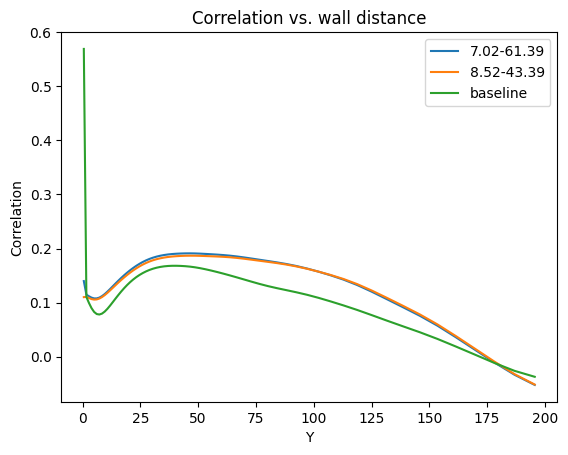

In [32]:

sigmas = [
    (7.019692195540223,  61.39130847868303),  # along_y.mean()
    (8.519757986068726, 43.39446657896042),  # along_y[32:64].mean()
]


import matplotlib.pyplot as plt
for s1, s2 in sigmas:
    avg_corr = get_avg_corr(full_images, full_fields, s1, s2)
    plt.plot(dataset.channel.get_simulation_channel().y_dimension[:64] * 200, avg_corr, label=f"{s1:.2f}-{s2:.2f}")
plt.plot(dataset.channel.get_simulation_channel().y_dimension[:64] * 200, baseline, label=f"baseline")
plt.xlabel('Y')
plt.ylabel('Correlation')
plt.title('Correlation vs. wall distance')
plt.legend()
plt.show()

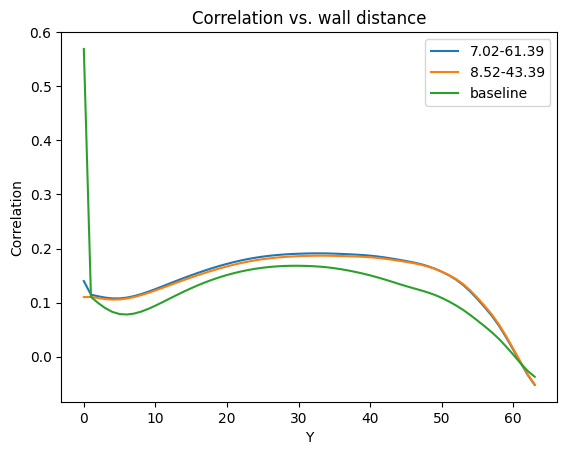

In [33]:
import matplotlib.pyplot as plt
for s1, s2 in sigmas:
    avg_corr = get_avg_corr(full_images, full_fields, s1, s2)
    plt.plot(avg_corr, label=f"{s1:.2f}-{s2:.2f}")
plt.plot(baseline, label=f"baseline")
plt.xlabel('Y')
plt.ylabel('Correlation')
plt.title('Correlation vs. wall distance')
plt.legend()
plt.show()